In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")

### Data Cleaning

In [2]:
df = pd.read_csv(r"data/h1b2019.csv")
# Base_salary string to int
df["base_salary"] = [int(i.replace(",", "")) for i in df["base_salary"]]
# extract month
df["submit_month"] = [int(i[:2]) for i in df["submit_date"]]
df["start_month"] = [int(i[:2]) for i in df["start_date"]]

In [3]:
# transform dates to datetime and extract the number of days between application submission and start date
df["submit_date"] = pd.to_datetime(df["submit_date"], infer_datetime_format=True)
df["start_date"] = pd.to_datetime(df["start_date"], infer_datetime_format=True)
df["diff"] = df["start_date"] - df["submit_date"]
# if the number of days less than 0 -> deleted 
df["diff"] = [i.days if i.days>0 else 0 for i in df["diff"]]
df["state"] = [i.split(", ")[-1] for i in df["location"]]
# Remove the state that are DE or missing
df = df[~df.state.isin(["DE", ""])]
df["city"] = [i.split(", ")[0] for i in df["location"]]
# remove any cities with less than 5 examples -> helps to get rid of the misspelled cities
df = df[df.city.isin(df["city"].value_counts()[df["city"].value_counts().values > 5].index)]

In [4]:
df.head(3)

,company,job_title,base_salary,location,submit_date,start_date,status,year,submit_month,start_month,diff,state,city
0,ACCENTURE LLP,ADVANCED APPLICATION ENGINEERING MANAGER,107500,"ATLANTA, GEORGIA",2019-01-08,2019-01-10,CERTIFIED,2019,1,1,2,GEORGIA,ATLANTA
1,ACCENTURE LLP,ADVANCED APPLICATION ENGINEERING MANAGER,107500,"ATLANTA, GEORGIA",2019-01-08,2019-01-10,CERTIFIED,2019,1,1,2,GEORGIA,ATLANTA
2,ACCENTURE LLP,ADVANCED APPLICATION ENGINEERING MANAGER,114982,"RESTON, VIRGINIA",2019-01-08,2019-01-10,CERTIFIED,2019,1,1,2,VIRGINIA,RESTON


In [191]:
print(df.shape)
df.head(3)

(495419, 13)


,company,job_title,base_salary,location,submit_date,start_date,status,year,submit_month,start_month,diff,state,city
0,ACCENTURE LLP,ADVANCED APPLICATION ENGINEERING MANAGER,107500,"ATLANTA, GEORGIA",2019-01-08,2019-01-10,CERTIFIED,2019,1,1,2,GEORGIA,ATLANTA
1,ACCENTURE LLP,ADVANCED APPLICATION ENGINEERING MANAGER,107500,"ATLANTA, GEORGIA",2019-01-08,2019-01-10,CERTIFIED,2019,1,1,2,GEORGIA,ATLANTA
2,ACCENTURE LLP,ADVANCED APPLICATION ENGINEERING MANAGER,114982,"RESTON, VIRGINIA",2019-01-08,2019-01-10,CERTIFIED,2019,1,1,2,VIRGINIA,RESTON


### Extract key words from job_title

In [6]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words("english")
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer("english")

In [79]:
def to_alpha(text):
    """
    Converting text to lower case as in, converting "Hello" to  "hello" or "HELLO" to "hello".
    and converts only alphabetic characters
    """
    return ' '.join([w.lower() for w in nltk.word_tokenize(text) if w.isalpha()])

def df_col_to_clean_text(df, col = "job_title"):
    str_comments = df[col].to_string(index=False)
    # lower all words and derive only alpha characters
    str_comments_alpha = to_alpha(str_comments)
    # from text - tokenize words
    word_tokens=nltk.word_tokenize(str_comments_alpha)
    # only keep the root of the word
    tokens_lem = [wordnet_lemmatizer.lemmatize(word) for word in word_tokens if word not in stop_words]
    stemmed_word = [snowball_stemmer.stem(word) for word in tokens_lem]
    #only keep words longer than 2, like gas etc
    w_tokens = [w for w in stemmed_word if len(w)>2]
    # convert to nltk text
    str_words2 = nltk.Text(w_tokens)
    return str_words2, w_tokens

def comment_to_clean_tokens(row):
    try:
        comment = row["job_title"]
        # lower all words and derive only alpha characters
        str_comments_alpha = to_alpha(comment)
        # from text - tokenize words
        word_tokens=nltk.word_tokenize(str_comments_alpha)
        # only keep the root of the word
        tokens_lem = [wordnet_lemmatizer.lemmatize(word) for word in word_tokens if word not in stop_words]
        stemmed_word = [snowball_stemmer.stem(word) for word in tokens_lem]
        #only keep words longer than 2, like gas etc
        w_tokens = [w for w in stemmed_word if len(w) > 2]
        # convert to nltk text
        return " ".join(w_tokens)
    except Exception:
        return "other"

In [18]:
df["tokens"] = df.apply(comment_to_clean_tokens, axis=1)

In [19]:
df.head(2)
# df[["company", "job_title", "tokens", "base_salary", "state", "city"]].to_csv("data/h1b19_clean.csv", index=False)

,company,job_title,base_salary,location,submit_date,start_date,status,year,submit_month,start_month,diff,state,city,tokens
0,ACCENTURE LLP,ADVANCED APPLICATION ENGINEERING MANAGER,107500,"ATLANTA, GEORGIA",2019-01-08,2019-01-10,CERTIFIED,2019,1,1,2,GEORGIA,ATLANTA,advanc applic engin manag
1,ACCENTURE LLP,ADVANCED APPLICATION ENGINEERING MANAGER,107500,"ATLANTA, GEORGIA",2019-01-08,2019-01-10,CERTIFIED,2019,1,1,2,GEORGIA,ATLANTA,advanc applic engin manag


In [25]:
df2 = pd.read_csv("data/h1b19_clean.csv")
df2.head(2)

,company,job_title,tokens,base_salary,state,city
0,ACCENTURE LLP,ADVANCED APPLICATION ENGINEERING MANAGER,advanc applic engin manag,107500,GEORGIA,ATLANTA
1,ACCENTURE LLP,ADVANCED APPLICATION ENGINEERING MANAGER,advanc applic engin manag,107500,GEORGIA,ATLANTA


### NLP

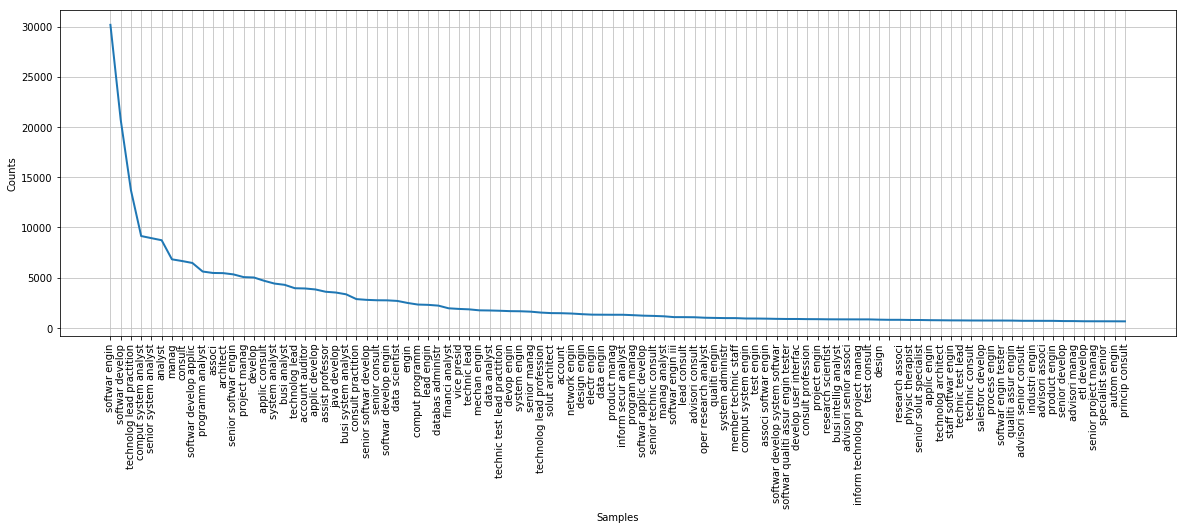

In [83]:
# top tokens in job_title
token_text = nltk.Text(df["tokens"])
fdist = nltk.FreqDist(token_text)
plt.figure(figsize = (20, 6))
fdist.plot(100)
plt.show()

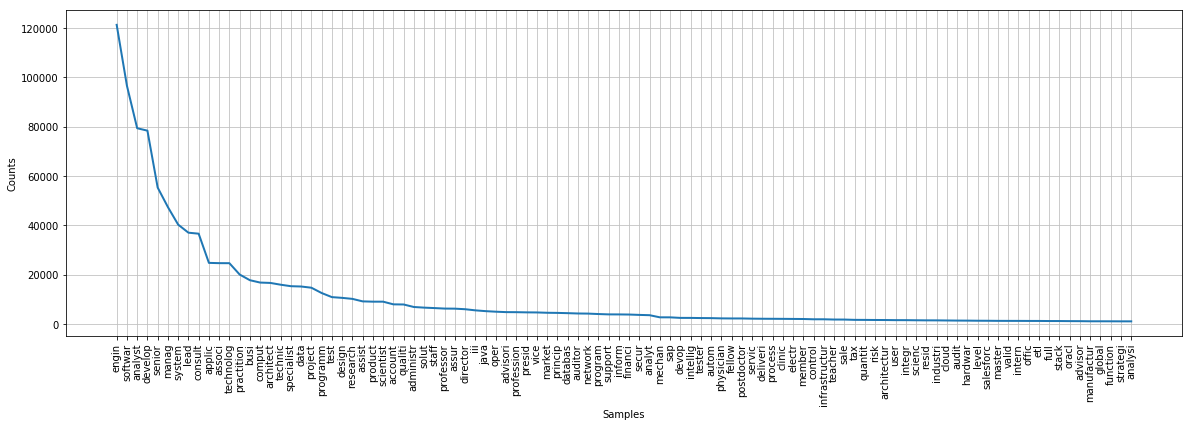

In [100]:
# extract tokens into a list 
token_array = []
for row in df["tokens"]:
    for i in row.split():
        token_array.append(i)
   
# Analyse by token
token_text = nltk.Text(token_array)
fdist = nltk.FreqDist(token_text)
plt.figure(figsize = (20, 6))
fdist.plot(100)
plt.show()

In [117]:
# Let's build the list of 'key' token words desribing a profession
key_title_tokens = ["engin", "develop", "architect", "administr", "account", "auditor",\
                    "analyst", "manag", "consult", "associ", "presid", "programm", "professor"]

# check how many items we covered by the above list
counter = 0
for row in df["tokens"]:
    for i in row.split():
        if i in key_title_tokens:
            counter += 1
            break
            # we break after finding any item as onyl want to count a row once if any of key words are in the job_title
      
round(counter/df.shape[0], 2)
# We cover 82% of job_title by just those key words - Yaaay!
# Now we can try to use this logic in our Dashboard Analytics

0.82

### Dashboard inputs

## Scatterplot

In [240]:
salary_choice = "mean" #mean - max - min 

In [257]:
x = df2.groupby("city").agg({"company": "count", "base_salary": salary_choice}).sort_values(by="company", ascending=False)[:500].values
y = df2.groupby("city").agg({"company": "count", "base_salary": salary_choice}).sort_values(by="company", ascending=False)[:500].values
cities = df2.groupby("city").agg({"company": "count", "base_salary": salary_choice}).sort_values(by="company", ascending=False)[:500].index.tolist()

### Top companies

In [ ]:
# City
# Find top Companies
# x ---> top 20 companies
# y_count -> count of jobs
# y_choice -> average, min, max salary

In [261]:
city = "NEW YORK"

top_companies = df2[df2.city == city].groupby("company").count()["job_title"].sort_values(ascending=False)[:20].index.tolist()
dff = df2[(df2.company.isin(top_companies)) & (df2.city == city)].drop(["state", "city"], axis=1)
dff_gp = dff.groupby("company").agg(\
                                    {"job_title": "count", "base_salary": salary_choice}\
                                   ).rename(columns={"job_title": "count"}).sort_values(by="count", ascending=False)
x = dff_gp.index
y_count = dff_gp["count"].values
y_choice = dff_gp["base_salary"].values

In [265]:
y_count

array([2554, 2433, 1329, 1146,  958,  809,  629,  602,  577,  560,  558,
        556,  453,  450,  446,  371,  356,  350,  339,  334], dtype=int64)

In [266]:
dff_gp

,count,base_salary
company,,
ERNST & YOUNG US LLP,2554,115833.289742
GOLDMAN SACHS & CO LLC,2433,136260.532622
JPMORGAN CHASE & CO,1329,126328.058691
MORGAN STANLEY SERVICES GROUP INC,1146,122033.636126
GOOGLE LLC,958,146274.771399
GOLDMAN SACHS SERVICES LLC,809,125974.042027
DELOITTE CONSULTING LLP,629,83192.810811
INFOSYS LIMITED,602,94650.936877
DELOITTE & TOUCHE LLP,577,73246.478336


### Top Roles

In [ ]:
# City
# Find top 'Roles'
# x ---> top 13 roles
# y_count -> count of jobs
# y_choice -> average, min, max salary

In [184]:
def getTokenSummary(dff, key_title_tokens):
    index_dict = {}
    for ind, row in enumerate(dff["tokens"]):
        try:
            for k in key_title_tokens:
                if k in row.split():
                    if k not in index_dict.keys():
                        index_dict[k] = []
                    index_dict[k].append(ind)
        except Exception:
            pass

    # structure - > key -> all -> [count, mean, min, max] , different title names -> keep top 10 roles and how many it represents
    result_dict = {}
    for k in index_dict.keys():
        df_temp = dff.iloc[index_dict[k]]
        result_dict[k] = {}
        # total
        my_list = [df_temp.shape[0], int(df_temp["base_salary"].mean()), 
                   int(df_temp["base_salary"].min()), 
                   int(df_temp["base_salary"].max())]
        result_dict[k]["all"] = my_list

        # by job_title type -> top 10
        top_roles = df_temp.groupby("tokens").agg({"company": "count",}).sort_values(by="company", ascending=False)[:10].index.tolist()
        top_roles_perc = round(df_temp.groupby("tokens").agg(\
                                                             {"company": "count"}\
                                                            ).sort_values(by="company",\
                                                                          ascending=False)[:10].company.sum()/df_temp.shape[0], 2)
        top_roles.append(top_roles_perc)
        result_dict[k]["top_roles"] = top_roles
        
    return result_dict

In [209]:
tokens_summary = getTokenSummary(dff, key_title_tokens)

In [203]:
x = [i for i in tokens_summary.keys()]
y_count = [tokens_summary[i]["all"][0] for i in [i for i in tokens_summary.keys()]]
y_choice = [tokens_summary[i]["all"][1] if salary_choice=="mean" \
            else tokens_summary[i]["all"][2] if salary_choice=="min" else tokens_summary[i]["all"][3] for i in x]

### Roles salary distribution

In [222]:
role = "analyst"
print("The below roles explain %s of roles that include this token word in its title" %(str(tokens_summary[role]["top_roles"][-1]) + "%"))
      
# dff

The below roles explain 0.88% of roles that include this token word in its title


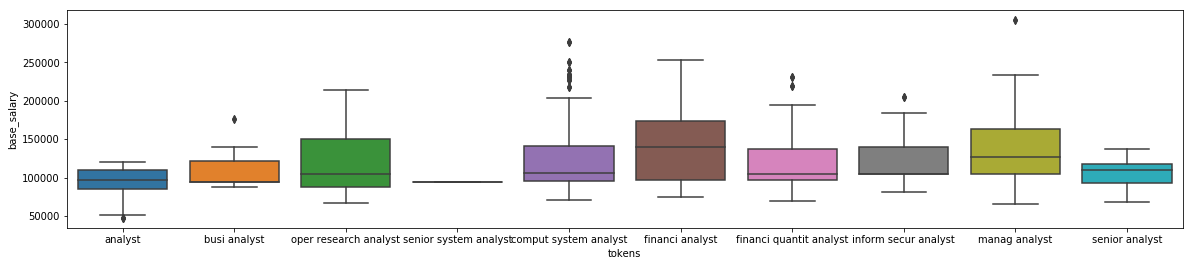

In [233]:
import seaborn
plt.figure(figsize=(20, 4))
sns.boxplot(x = dff[dff.tokens.isin(tokens_summary[role]["top_roles"][:-1])]["tokens"], \
            y = dff[dff.tokens.isin(tokens_summary[role]["top_roles"][:-1])]["base_salary"])
plt.show()

### Analysis - Visualisation

In [192]:
# Support Functions

def filterData(df, column, my_list):
    return df[df[column].isin(my_list)]

def topColumn(df, column, top=20):
    return df[[column, "status"]].groupby(column).count().sort_values(by="status", ascending=False)[:top].index.tolist()

### Salary distribution for the top 20 companies (by the number of applications)

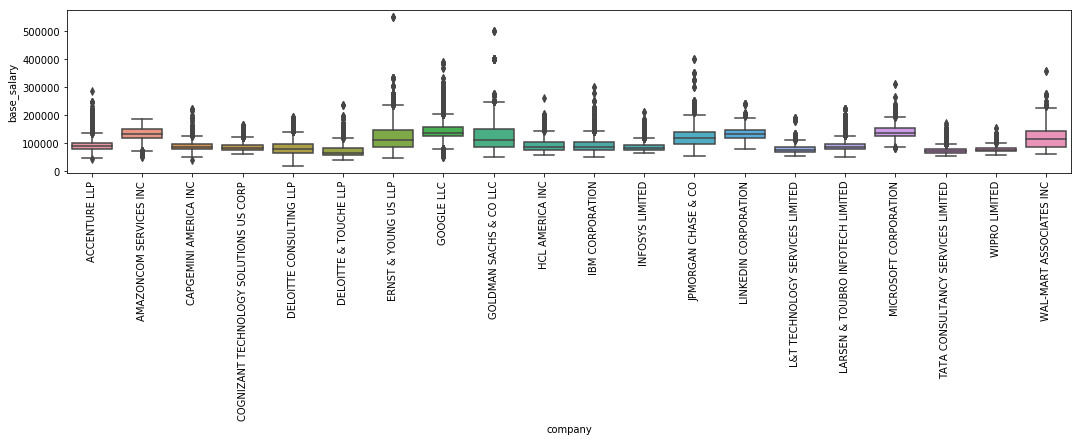

In [193]:
plt.figure(figsize=(18, 3))
sns.boxplot(data=filterData(df, "company", topColumn(df, "company")), x="company", y="base_salary")
plt.xticks(rotation=90)
plt.show()

**Comments**

1. Goldman, Google, EY, Amazon, JPMorgan, Microsoft - noticeably higher salary distribution than the rest of companies

<br>

### Salary distribution for 20 most popular job titles (by the number of applications)

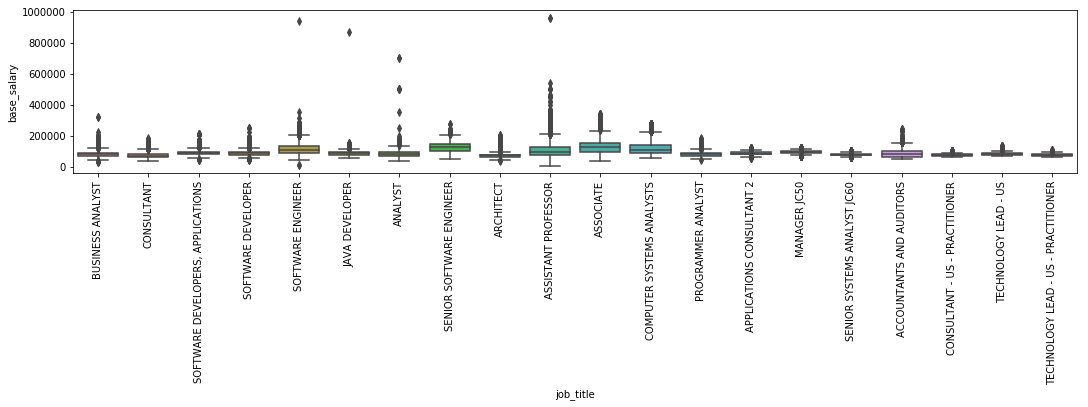

In [194]:
plt.figure(figsize=(18, 3))
sns.boxplot(data=filterData(df, "job_title", topColumn(df, "job_title")), x="job_title", y="base_salary")
plt.xticks(rotation=90)
plt.show()

### Top H1B providers

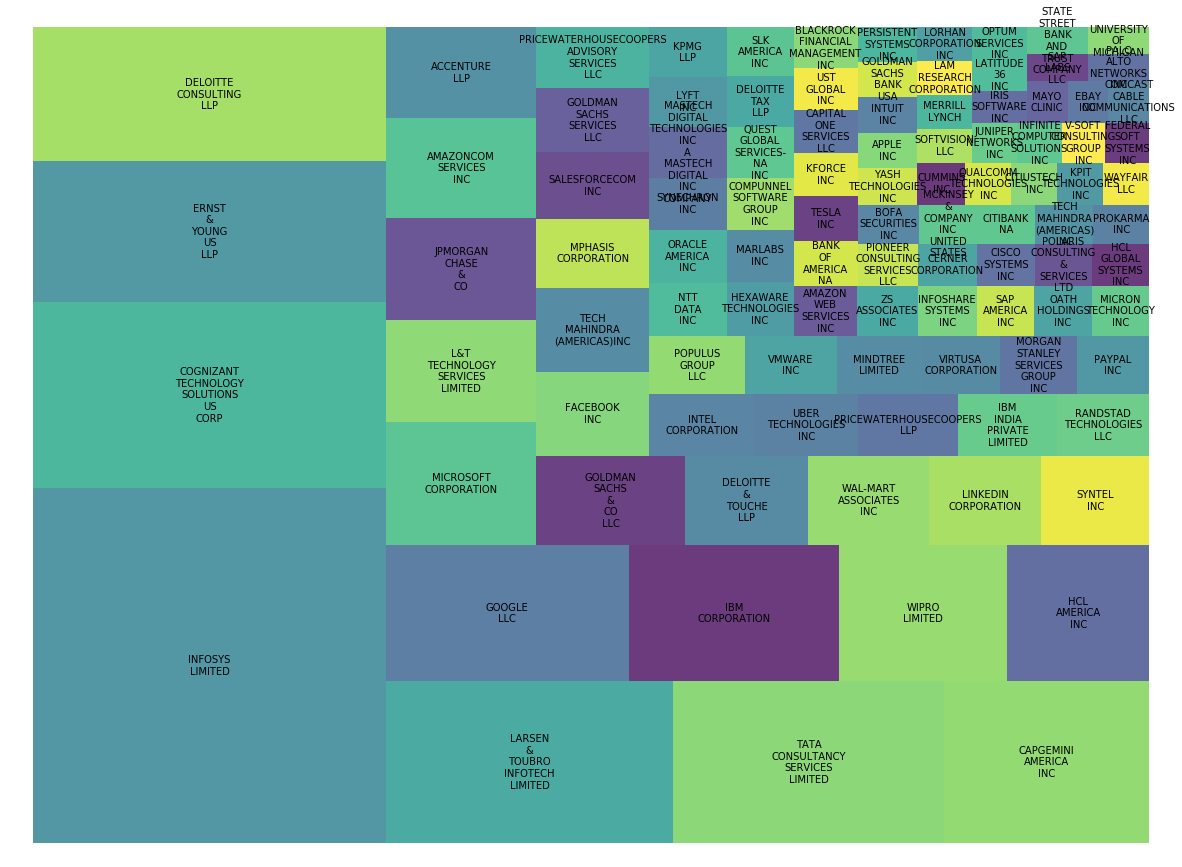

In [85]:
def dfGroupby(df, column, top=100):
    return df[[column, "status"]].groupby(column).count().sort_values(by="status", ascending=False)[:100]
plt.figure(figsize=(20, 15))
squarify.plot(sizes=dfGroupby(df, "company").status, label=["\n".join(i.split()) for i in dfGroupby(df, "company").index], alpha=.8 )
plt.axis('off')
plt.show()

**Comments**

1. Deloitte, EY, Infosys, Cognizant -> top H1B providers

<br>

### Top job titles with H1B

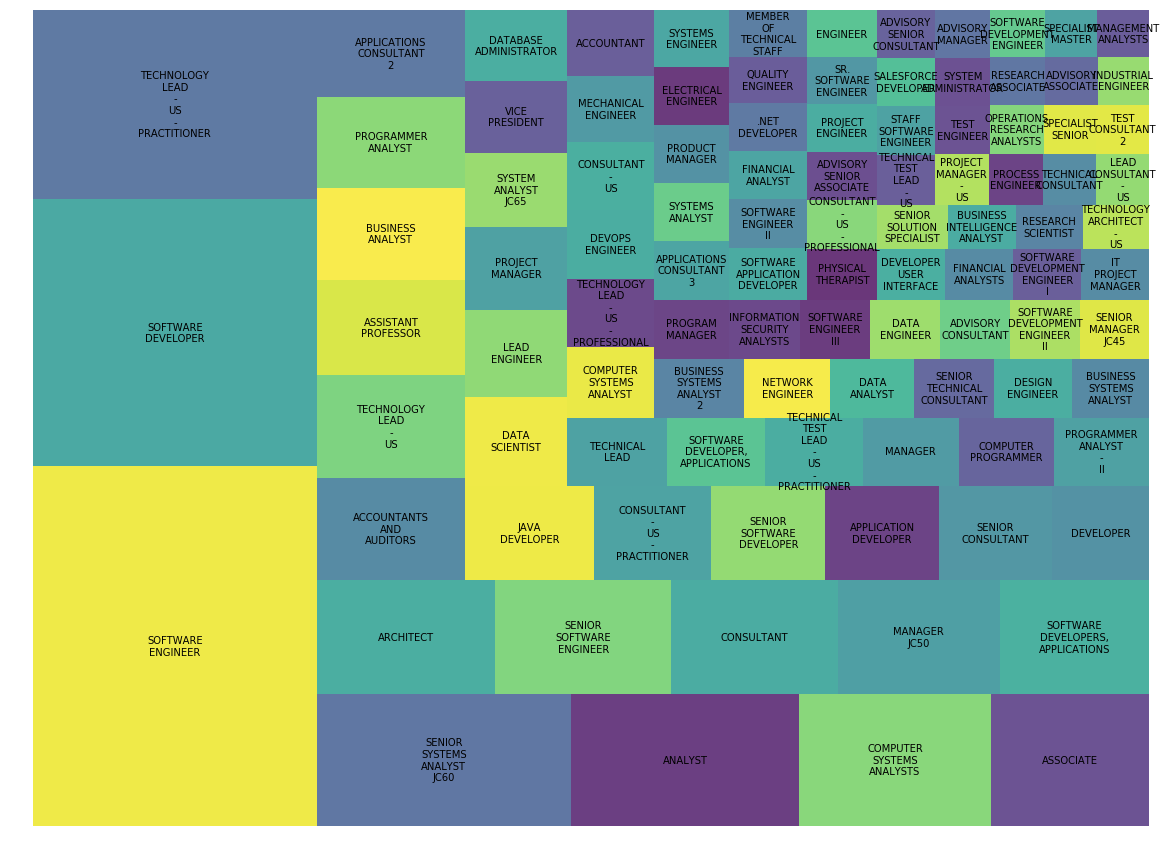

In [84]:
plt.figure(figsize=(20, 15))
squarify.plot(sizes=dfGroupby(df, "job_title").status, label=["\n".join(i.split()) for i in dfGroupby(df, "job_title").index], alpha=.8 )
plt.axis('off')
plt.show()

### Distribution of the days application submited before the start date

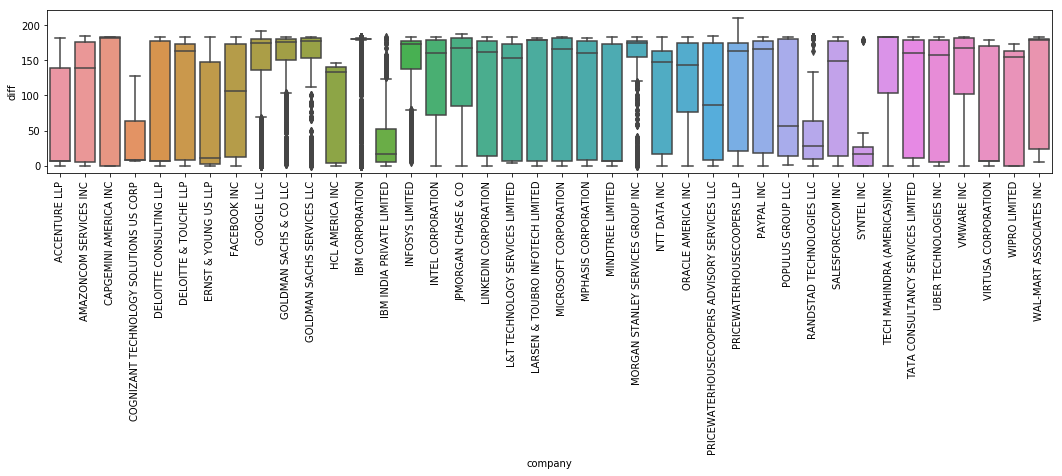

In [196]:
plt.figure(figsize=(18, 3))
sns.boxplot(data=filterData(df, "company", topColumn(df, "company", top=40)), x="company", y="diff")
plt.xticks(rotation=90)
plt.show()

**Comments**

1. IBM India Private Ltd submits most of the applications aroud 30 days before start date, which is significantly earlier than other companies
2. Most companies submit around 180 days before start date
3. Google, Goldman, Mogran Stanley submit most of their applications around 180 days in advance, but have many applications that are submitted much earlier

<br>

### Top 20 companies - distribution of days applications submitted before the start date

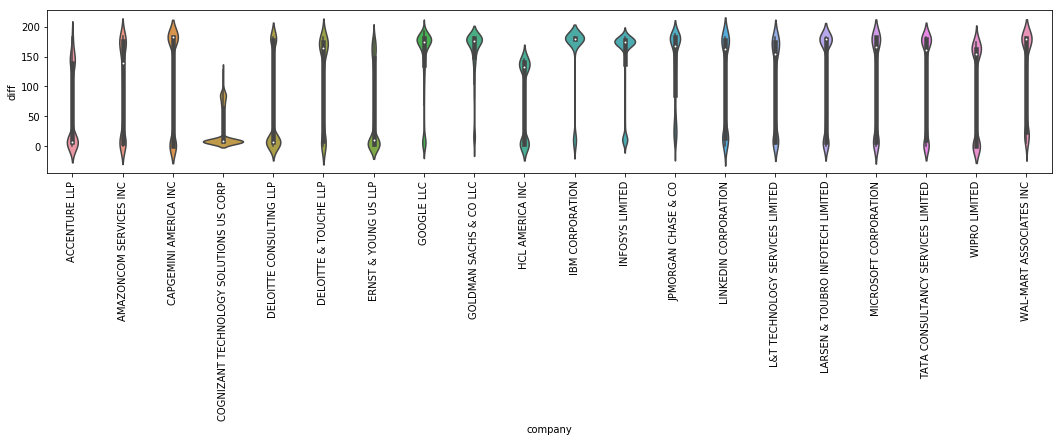

In [197]:
plt.figure(figsize=(18, 3))
sns.violinplot(data=filterData(df, "company", topColumn(df, "company", top=20)), x="company", y="diff")
plt.xticks(rotation=90)
plt.show()

### Salary by state and city

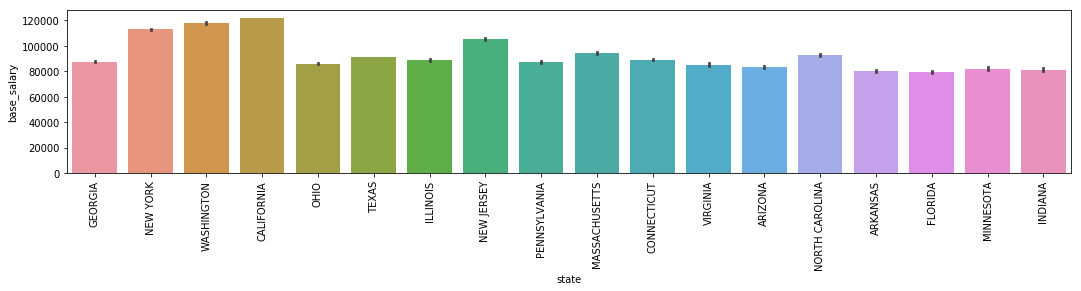

In [195]:
plt.figure(figsize=(18, 3))
sns.barplot(data=filterData(df, "location", topColumn(df, "location", top=40)), x="state", y="base_salary")
plt.xticks(rotation=90)
plt.show()

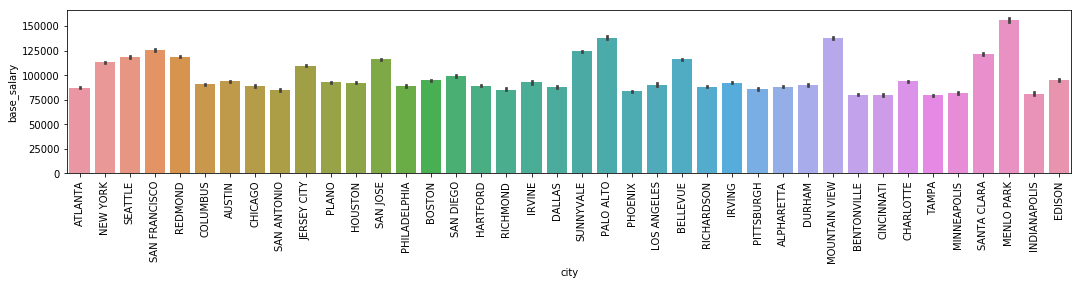

In [198]:
plt.figure(figsize=(18, 3))
sns.barplot(data=filterData(df, "location", topColumn(df, "location", top=40)), x="city", y="base_salary")
plt.xticks(rotation=90)
plt.show()

**Comments**

1. Top three states for highest salaries: California, Washington, New York
2. Top cities for highest salaries: Menlo Park (CA), Mountain View (CA), Palo Alto (CA), Sunnyvale (CA), 
Santa Clara (CA), San Francisco (CA), New York. 

<br>

### Top job titles by top 20 companies

INFOSYS LIMITED
--------


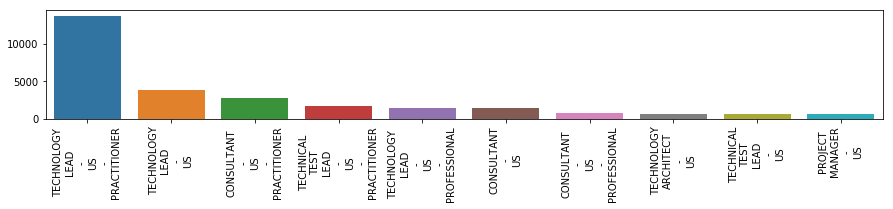

COGNIZANT TECHNOLOGY SOLUTIONS US CORP
--------


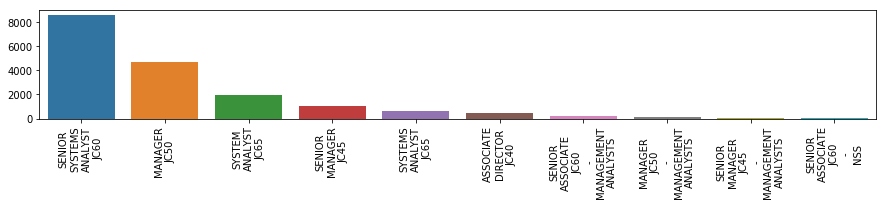

ERNST & YOUNG US LLP
--------


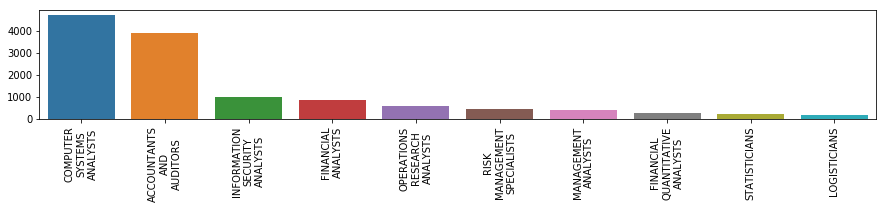

DELOITTE CONSULTING LLP
--------


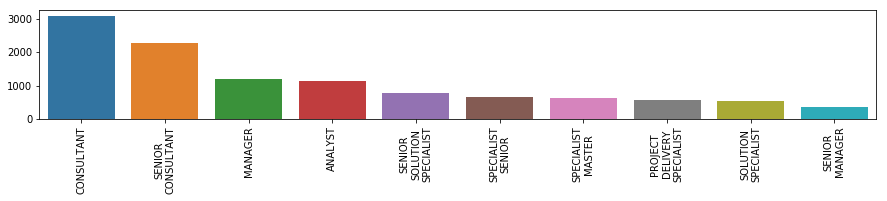

LARSEN & TOUBRO INFOTECH LIMITED
--------


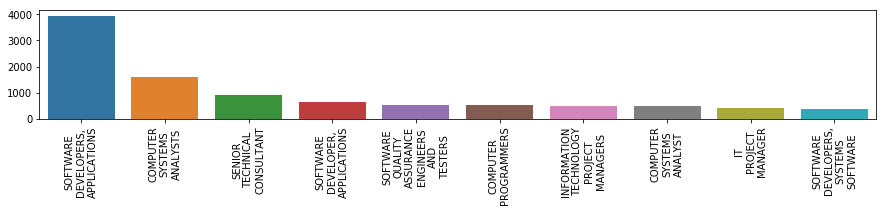

TATA CONSULTANCY SERVICES LIMITED
--------


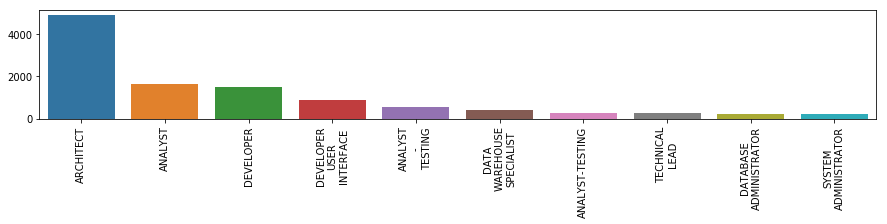

CAPGEMINI AMERICA INC
--------


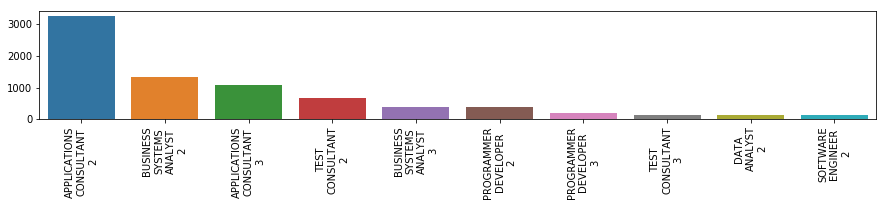

GOOGLE LLC
--------


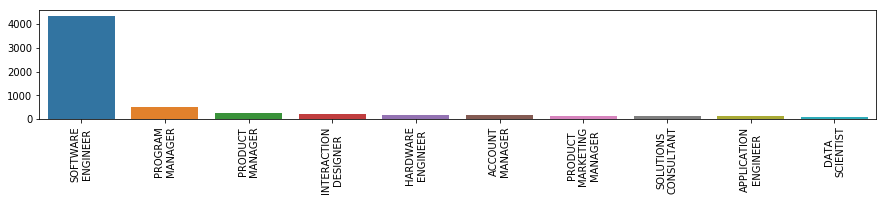

IBM CORPORATION
--------


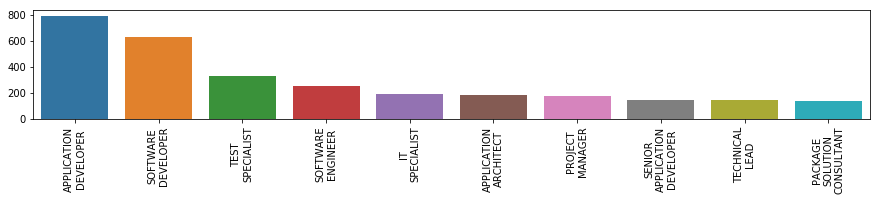

WIPRO LIMITED
--------


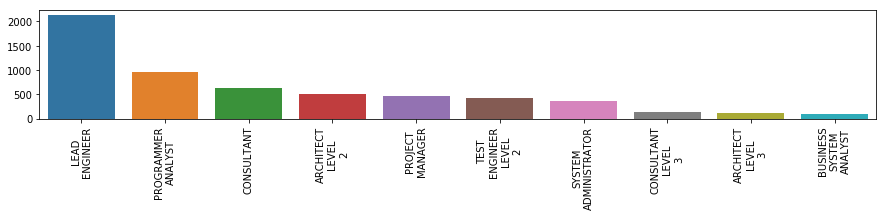

In [202]:
top20companies = topCompanies(df, top=10)
for c in top20companies:
    print(c)
    print("--------")
    plt.figure(figsize=(15, 2))
    sns.barplot(x=["\n".join(i.split()) for i in df[df.company == c].groupby("job_title").count()["company"].sort_values(ascending=False)[:10].index], 
               y=df[df.company == c].groupby("job_title").count()["company"].sort_values( ascending=False)[:10].values)
    plt.xticks(rotation=90)
    plt.show()

### Percentage of job title belonging to specific state

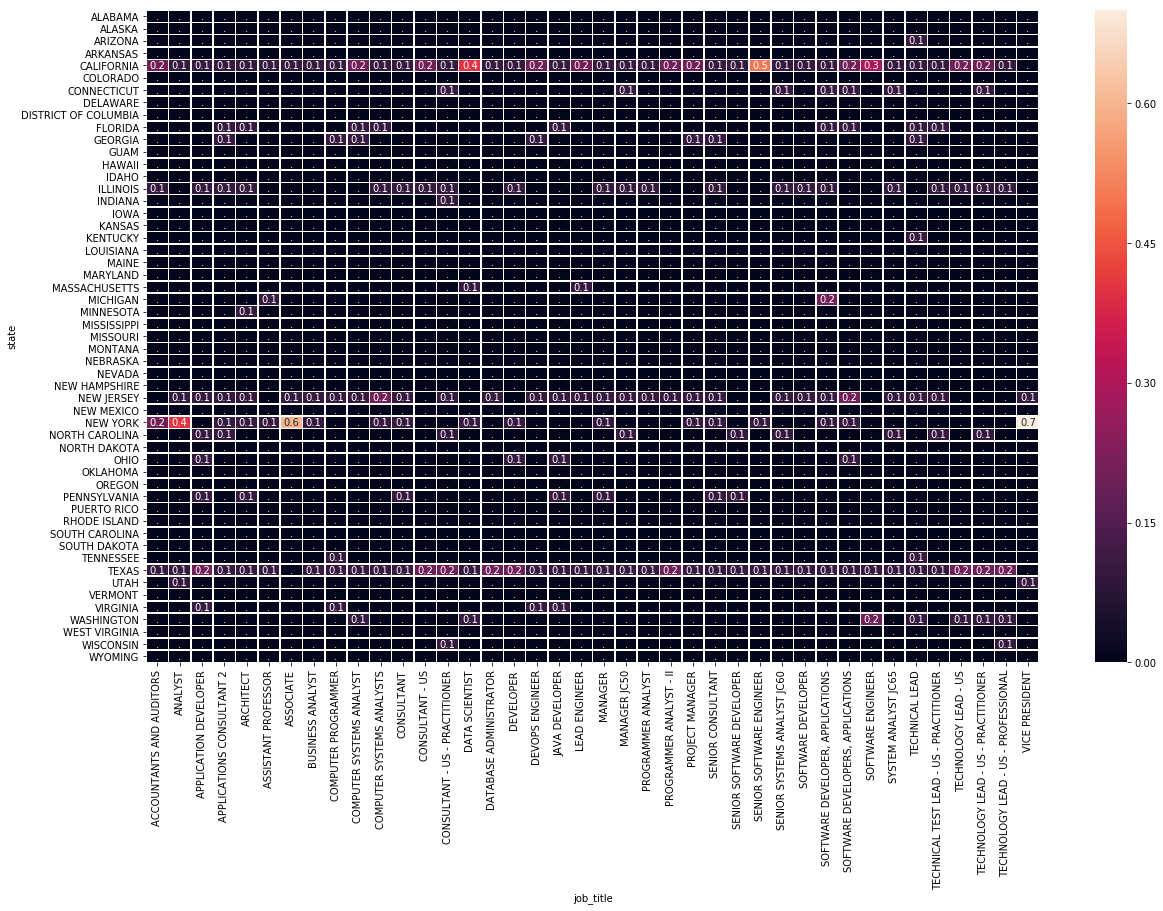

In [180]:
topJobs = topRoles(df, top=40)

pv = pd.pivot_table(data=df[df.job_title.isin(topJobs)], 
               index="state", columns="job_title", values="company", aggfunc="count", fill_value=0)
pv = round(pv/pv.sum(), 1)
pv_annot = pv.replace(0, ".")
plt.figure(figsize = (20, 12))
sns.heatmap(pv, annot=pv_annot.astype(str), fmt="", linewidths=.5)
plt.show()

**Comments**

1. 60% Associate, 70% of VP, 40% of Analyst job titles belong to New York
2. 40% of Data Scientist, 50% of Software Engineer job titles belong to California
3. New York, California, New Jersey and Texas have the most presence

<br>

### Company's presence per state

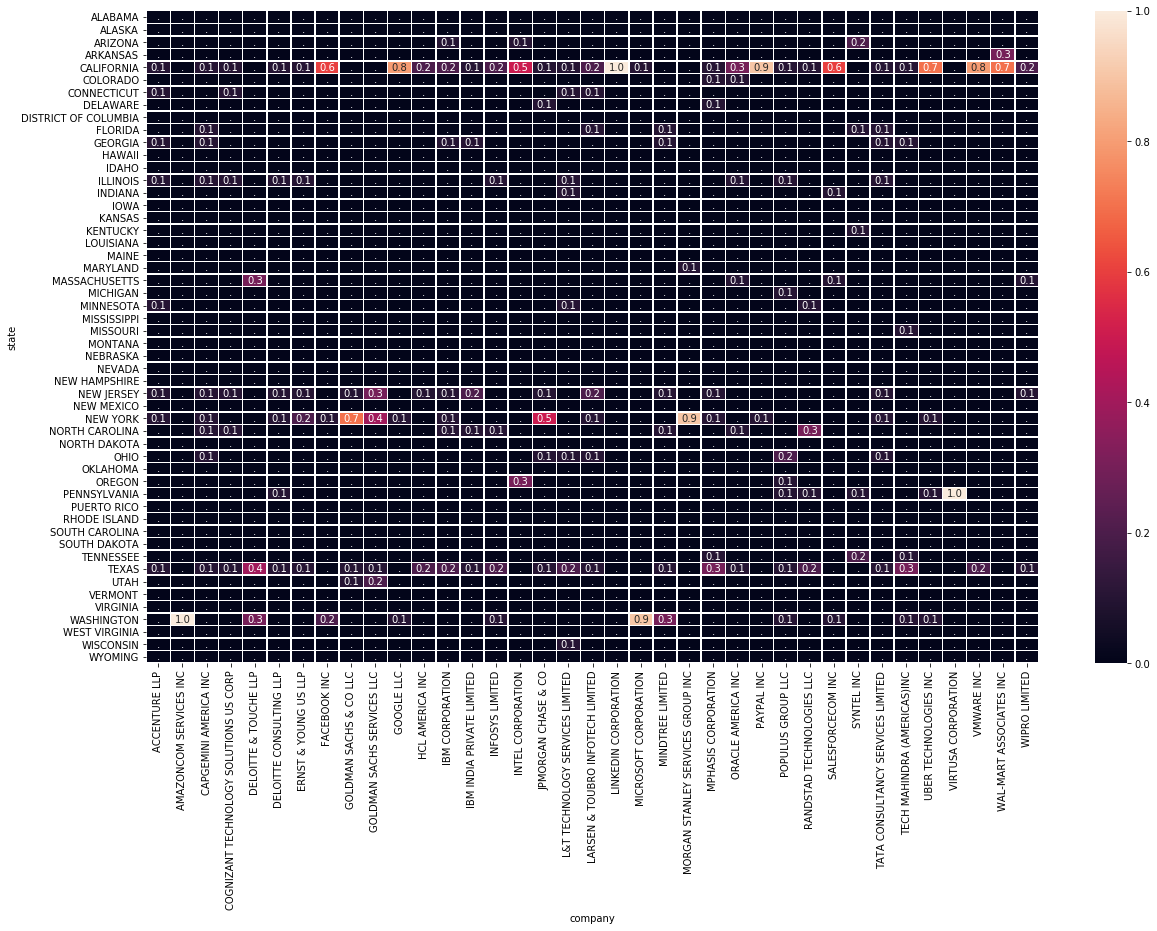

In [181]:
topJobs = topRoles(df, top=40)
topComp = topCompanies(df, top=40)

pv = pd.pivot_table(data=df[(df.job_title.isin(topJobs)) & (df.company.isin(topComp))], 
               index="state", columns="company", values="status", aggfunc="count", fill_value=0)
pv = round(pv/pv.sum(), 1)
pv_annot = pv.replace(0, ".")
plt.figure(figsize = (20, 12))
sns.heatmap(pv, annot=pv_annot.astype(str), fmt="", linewidths=.5)
plt.show()

**Comments**

1. Amazon, Microsoft -> Washington
2. Goldman, Morgan Stanely -> New York
3. Facebook, Google, LinkedIn, Paypal, Uber -> California

<br>

### Job title presence per company

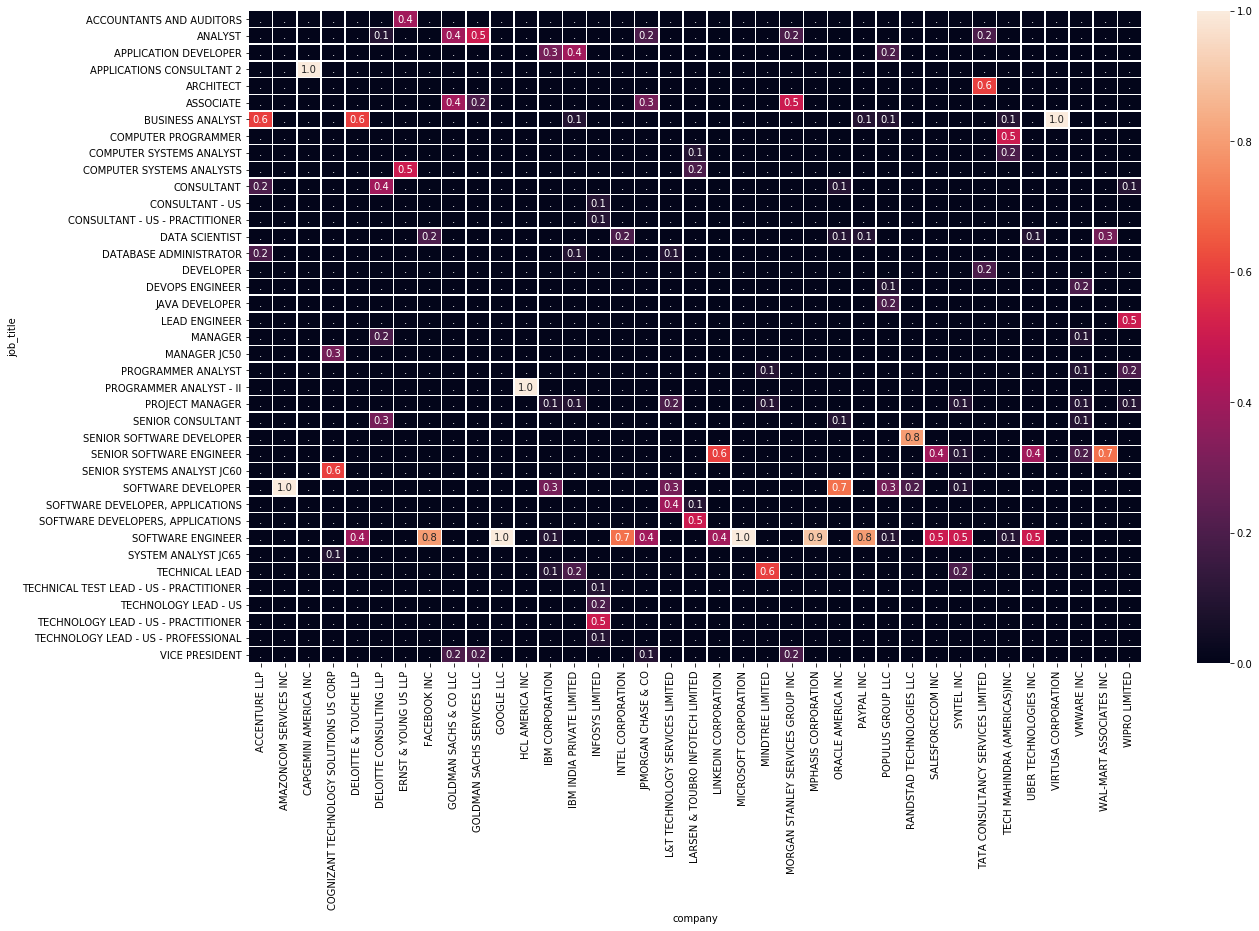

In [183]:
topJobs = topRoles(df, top=40)
topComp = topCompanies(df, top=40)

pv = pd.pivot_table(data=df[(df.job_title.isin(topJobs)) & (df.company.isin(topComp))], 
               index="job_title", columns="company", values="status", aggfunc="count", fill_value=0)
pv = round(pv/pv.sum(), 1)
pv_annot = pv.replace(0, ".")
plt.figure(figsize = (20, 12))
sns.heatmap(pv, annot=pv_annot.astype(str), fmt="", linewidths=.5)
plt.show()

**Comments**

1. Software Developer -> Amazon, Oracle
2. Software Engineer -> Microsoft, Google, Mphasis

<br>

### Scatter plots -> will look better in Interactive Plotly

In [201]:
# Support Function
def get_scatter_data(df, by):
    return df[[by, "base_salary", "status"]].groupby([by], as_index=False).agg({"base_salary": "mean", "status": "count"})

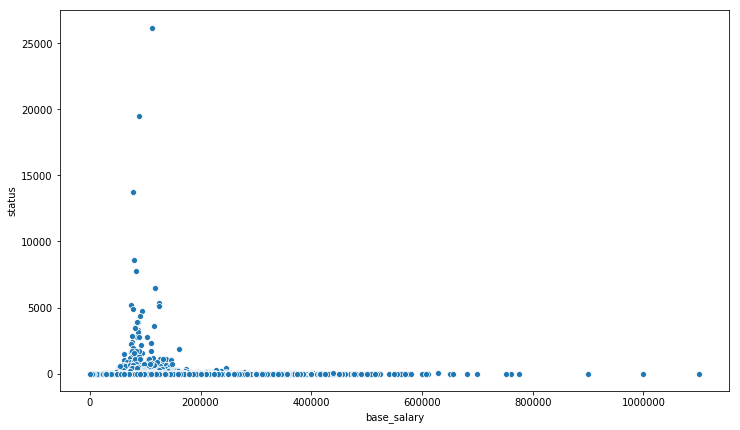

In [44]:
plt.figure(figsize=(12, 7))
dff = get_scatter_data(df, "job_title")
sns.scatterplot(data=dff, x="base_salary", y="status")
plt.show()

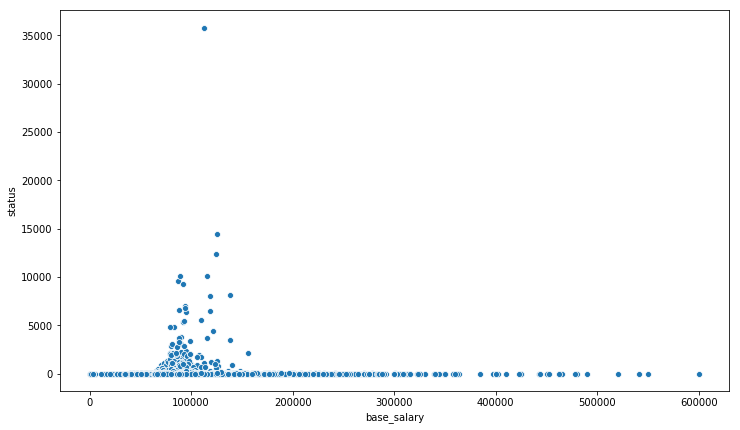

In [47]:
plt.figure(figsize=(12, 7))
dff = get_scatter_data(df, "location")
sns.scatterplot(data=dff, x="base_salary", y="status")
plt.show()

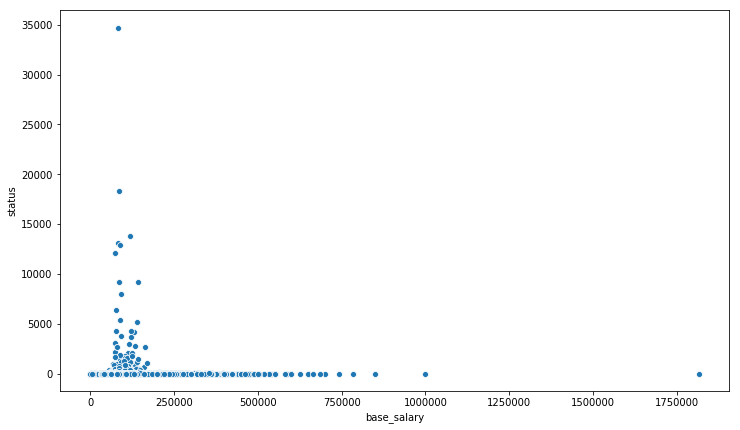

In [49]:
plt.figure(figsize=(12, 7))
dff = get_scatter_data(df, "company")
sns.scatterplot(data=dff, x="base_salary", y="status")
plt.show()